In [1]:
%matplotlib inline

# Introduction to Geometric Quantum Machine Learning


Symmetries are at the heart of physics. Indeed in condensed matter and particle physics we often define a thing simply by the symmetries it adheres to. What does symmetry mean for those in machine learning? In this context the ambition is straightforward --- it is a means to reduce the parameter space and improve the trained model\'s ability to sucessfully label unseen data, i.e., its ability to generalise.

Suppose we have a learning task and the data we are learning from has an underlying symmetry. For example, consider a game of Noughts and Crosses (aka Tic-tac-toe): if we win a game, we would have won it if the board was rotated or flipped along any of the lines of symmetry. Now if we want to train an algorithm to spot the outcome of these games, we can either ignore the existence of this symmetry or we can somehow include
it. The advantage of paying attention to the symmetry is it identifies multiple configurations of the board as \'the same thing\' as far as the symmetry is concerned. This means we can reduce our parameter space, and
so the amount of data our algorithm must sift through is immediately reduced. Along the way, the fact that our learning model must encode a symmetry that actually exists in the system we are trying to represent
naturally encourages our results to be more generalisable. The encoding of symmetries into our learning models is where the term *equivariance* will appear. We will see that demanding that certain symmetries are
included in our models means that the mappings that make up our algorithms must be such that we could transform our input data with respect to a certain symmetry, then apply our mappings, and this would
be the same as applying the mappings and then transforming the output data with the same symmetry. This is the technical property that gives us the name \"equavariant learning\".

In classical machine learning, this area is often referred to as geometric deep learning (GDL) due to the traditional association of symmetry to the world of geometry, and the fact that these considerations usually focus on deep neural networks (see Michael M. Bronstein, Joan Bruna, Taco Cohen, Petar Veličković (2021). Geometric Deep Learning: Grids, Groups, Graphs, Geodesics, and Gauges. arXiv:2104.13478
 or Quynh T. Nguyen, Louis Schatzki, Paolo Braccia, Michael Ragone, Patrick J. Coles, Frédéric Sauvage, Martín Larocca, and M. Cerezo (2022). Theory for Equivariant Quantum Neural Networks. arXiv:2210.08566
 for a broad introduction). We will refer to the quantum computing version of this as *quantum geometric machine learning* (QGML).

## Representation theory in circuits


The first thing to discuss is how do we work with symmetries in the first place? The answer lies in the world of group representation theory.

First, let\'s define what we mean by a group:

**Definition**: A group is a set $G$ together with a binary operation on
$G$, here denoted $\circ$, that combines any two elements $a$ and $b$ to
form an element of $G$, denoted $a \circ b$, such that the following
three requirements, known as group axioms, are satisfied as follows:

1.  **Associativity**: For all $a, b, c$ in $G$, one has

    $(a \circ b) \circ c=a \circ (b \circ c)$.

2. **Identity element**: There exists an element $e$ in $G$ such that, for every $a$ in $G$, one
    :   has $e \circ a=a$ and $a \circ e=a$. Such an element is unique.
        It is called the identity element of the group.

3.  **Inverse element**: For each $a$ in $G$, there exists an element $b$ in $G$
    :   such that $a \circ b=e$ and $b \circ a=e$, where $e$ is the
        identity element. For each $a$, the element $b$ is unique: it is
        called the inverse of $a$ and is commonly denoted $a^{-1}$.

With groups defined, we are in a position to articulate what a representation is: Let $\varphi$ be a map sending $g$ in group $G$ to a linear map $\varphi(g): V \rightarrow V$, for some vector space $V$, which satisfies

$$\varphi\left(g_{1} g_{2}\right)=\varphi\left(g_{1}\right) \circ \varphi\left(g_{2}\right) \quad \text { for all } g_{1}, g_{2} \in G.$$

The idea here is that just as elements in a group act on each other to reach further elements, i.e., $g\circ h = k$, a representation sends us to a mapping acting on a vector space such that $\varphi(g)\circ \varphi(h) = \varphi(k)$. In this way we are representing the structure of the group as a linear map. For a representation, our mapping must send us to the general linear group $GL(n)$ (the space of invertible $n \times n$ matrices with matrix multiplication as the group multiplication). Note how this is both a group, and by virtue of being a collection of invertible matrices, also a set of linear maps (they\'re all invertble matrices that can act on
row vectors). Fundamentally, representation theory is based on the prosaic observation that linear algebra is easy and group theory is abstract. So what if we can study groups via linear maps?

Now due to the importance of unitarity in quantum mechnics, we are particularly interested in the unitary representations: representations where the linear maps are unitary matrices. If we can identify these then we will have a way to naturally encode groups in quantum circuits (which are mostly made up of unitary gates).

![](images/sphere_equivariant.png)

How does all this relate to symmetries? Well, a large class of symmetries can be characterised as a group, where all the elements of the group leave some space we are considering unchanged. Let\'s consider an example: the symmetries of a sphere. Now when we think of this symmetry we probably think something along the lines of \"it\'s the same no matter how we rotate it, or flip it left to right, etc\". There is this idea of being invariant under some operation. We also have the idea of being able to undo these actions: if we rotate one way, we can rotate it back. If we flip the sphere right-to-left we can flip it left-to-right to get back to where we started (notice too all these inverses are unique). Trivially we can also do nothing. What exactly are we describing here? We have elements that correspond to an action on a sphere that can be inverted and for which there exists an identity. It is also trivially the case here that if we consider three operations a, b, c from the set of rotations and reflections of the sphere, that if we combine two of them together then $a\circ (b \circ c) = (a\circ b) \circ c$. The operations are associative. These features turn out to literally define a group!

As we\'ve seen the group in itself is a very abstract creature; this is why we look to its representations. The group labels what symmetries we care about, they tell us the mappings that our system is invariant under, and the unitary representations show us how those symmetries look on a particular space of unitary matrices. If we want to encode the structure of the symmeteries in a quantum circuit we must restrict our gates to being unitary representations of the group.

There remains one question: *what is equivariance?* With our newfound knowledge of group representation theory we are ready to tackle this. Let $G$ be our group, and $V$ and $W$, with elements $v$ and $w$ respectively, be vector spaces over some field $F$ with a map $f$ between them. Suppose we have representations $\varphi: G \rightarrow GL(V)$ and $\psi: G \rightarrow GL(W)$. Furthermore, let\'s write $\varphi_g$ for the representation of $g$ as a
linear map on $V$ and $\psi_g$ as the same group element represented as a linear map on $W$ respectively. We call $f$ *equivariant* if

$$f(\varphi_g(v))=\psi_g(f(v)) \quad \text { for all } g\in G.$$

The importance of such a map in machine learning is that if, for example, our neural network layers are equivariant maps then two inputs that are related by some intrinsic symmetry (maybe they are reflections) preserve this information in the outputs.

Consider the following figure for example. What we see is a board with a cross in a certain square on the left and some numerical encoding of this on the right, where the 1 is where the X is in the number grid. We
present an equivariant mapping between these two spaces with respect to a group action that is a rotation or a swap (here a $\pi$ rotation). We can either apply a group action to the original grid and then map to the number grid, or we could map to the number grid and then apply the group action. Equivariance demands that the result of either of these procedures should be the same.

![](images/equivariant-example.jpg)

Given the vast amount of input data required to train a neural network the principle that one can pre-encode known symmetry structures into the network allows us to learn better and faster. Indeed it is the reason
for the success of convolutional neural networks (CNNs) for image analysis, where it is known they are equivariant with respect to translations. They naturally encode the idea that a picture of a dog is symmetrically related to the same picture slid to the left by n pixels, and they do this by having neural network layers that are equivariant maps. With our focus on unitary representations (and so quantum circuits) we are looking to extend this idea to quantum machine learning.


## Categories of Geometric Deep Learning

In Bronstein’s recent book [Bronstein, Bruna, Cohen, Velickovic, Geometric Deep Learning: Grids, Groups, Graphs, Geodesics, and Gauges (2021), arXix:2104.13478], geometric deep learning is classified into four fundamental categories, as illustrated in the diagram below.

![](images/gdl-categories.png)

The grid category captures regularly sampled, or gridded, data such as 2D images. These data would perhaps typically be the purveyance of classical deep learning. However, it is also possible to interpret many of the classical deep learning models in a geometric perspective (such as CNNs an their translational equivariance, as discussed above).

The group category covers homogenous spaces with global symmetries. The canonical example of this category is the sphere (covered in greater detail in our previous article [3]). Spherical data arise in myrad applications, not only when data is acquired directly on the sphere (such as over the Earth or by 360° cameras that capture panoramic photos and videos), but also when considering spherical symmetries (such as in molecular chemistry or magnetic resonance imaging). While the sphere is the most common group setting, other groups and their corresponding symmetries can also be considered.

The graph category covers data that may be represented by a computational graph, with nodes and edges. Networks are well-suited to such representations, hence graph deep learning has found wide application in the study of social networks. The graph approach to geometric deep learning provides great flexibility since much data can be represented by a graph. However, this flexibility can come with a loss in specificity and the advantages that affords. For example, the group setting can often be considered with a graph approach but in this case one loses the underlying knowledge of the group, which can otherwise be leveraged.

The final geodesics and gauges category involves deep learning on more complex shapes, such as more general maniolds and 3D meshes. Such approaches can be of great use in computer vision and graphics, for example, where one can perform deep learning with 3D models and their deformations.


## Noughts and Crosses


Let\'s look at the game of noughts and crosses, as inspired by. Two players take turns to place a O or an X, depending on which player they are, in a 3x3 grid. The aim is to get three of your symbols in a row, column, or diagonal. As this is not always possible depending on the choices of the players, there could be a draw. Our learning task is to take a set of completed games labelled with their outcomes and teach the algorithm to identify these correctly.


This board of nine elements has the symmetry of the square, also known as the *dihedral group*. This means it is symmetric under $\frac{\pi}{2}$ rotations and flips about the lines of symmetry of a square (vertical, horizontal,and both diagonals).


![](images/NandC_sym.png)


**The question is, how do we encode this in our QML problem?**

First, let us encode this problem classically. We will consider a nine-element vector $v$, each element of which identifies a square of the board. The entries themselves can be $+1$,$0$,$-1,$ representing a nought, no symbol, or a cross. The label is one-hot encoded in a vector $y=(y_O,y_- , y_X)$ with $+1$ in the correct label and $-1$ in the others. For instance (-1,-1,1) would represent an X in the relevant position.


To create the quantum model let us take nine qubits and let them represent squares of our board. We\'ll initialise them all as $|0\rangle$, which we note leaves the board invariant under the symmetries of the problem (flip and rotate all you want, it\'s still going to be zeroes whatever your mapping). We will then look to apply single qubit $R_x(\theta)$ rotations on individual qubits, encoding each of the possibilities in the board squares at an angle of $\frac{2\pi}{3}$ from each other. For our parameterised gates we will have a single-qubit $R_x(\theta_1)$ and $R_y(\theta_2)$ rotation at each point. We will then use $CR_y(\theta_3)$ for two-qubit entangling gates.

This implies that, for each encoding, crudely, we\'ll need 18 single-qubit rotation parameters and $\binom{9}{2}=36$ two-qubit gate rotations. Let\'s see how, by using symmetries, we can reduce this.

![..](images/grid.jpg)

The indexing of our game board.


The secret will be to encode the symmetries into the gate set so the observables we are interested in inherently respect the symmetries. How do we do this? We need to select the collections of gates that commute with the symmetries. In general, we can use the twirling formula for this:


**Tip**

Let $\mathcal{S}$ be the group that encodes our symmetries and $U$ be a unitary representation of $\mathcal{S}$. Then,

$$\mathcal{T}_{U}[X]=\frac{1}{|\mathcal{S}|} \sum_{s \in \mathcal{S}} U(s) X U(s)^{\dagger}$$

defines a projector onto the set of operators commuting with all elements of the representation, i.e.,

$\left[\mathcal{T}_{U}[X], U(s)\right]=$ 0 for all $X$ and $s \in \mathcal{S}$.


The twirling process applied to an arbitrary unitary will give us a new unitary that commutes with the group as we require. We remember that unitary gates typically have the form $W = \exp(-i\theta H)$, where $H$ is a Hermitian matrix called a *generator*, and $\theta$ may be fixed or left as a free parameter. A recipe for creating a unitary that commutes with our symmetries is to *twirl the generator of the gate*, i.e., we move from the gate $W = \exp(-i\theta H)$ to the gate $W' = \exp(-i\theta\mathcal{T}_U[H])$. When each term in the twirling formula acts on different qubits, then this unitary would further simplify to

$$W' = \bigotimes_{s\in\mathcal{S}}U(s)\exp(-i\tfrac{\theta}{\vert\mathcal{S}\vert})U(s)^\dagger.$$

For simplicity, we can absorb the normalization factor $\vert\mathcal{S}\vert$ into the free parameter $\theta$.

So let\'s look again at our choice of gates: single-qubit $R_x(\theta)$ and $R_y(\theta)$ rotations, and entangling two-qubit $CR_y(\phi)$ gates. What will we get by twirling these?


In this particular instance we can see the action of the twirling operation geometrically as the symmetries involved are all permutations. Let\'s consider the $R_x$ rotation acting on one qubit. Now if this qubit is in the centre location on the grid, then we can flip around any symmetry axis we like, and this operation leaves the qubit invariant, so we\'ve identified one equivariant gate immediately. If the qubit is on the corners, then the flipping will send this qubit rotation to each of the other corners. Similarly, if a qubit is on the central edge then the rotation gate will be sent round the other edges. So we can see that the twirling operation is a sum over all the possible outcomes of performing the symmetry action (the sum over the symmetry group actions). Having done this we can see that for a single-qubit rotation the invariant maps are rotations on the central qubit, at all the corners, and at all the central edges (when their rotation angles are fixed to be the same).

As an example consider the following figure, where we take a $R_x$ gate in the corner and then apply all the symmetries of a square. The result of this twirling leads us to have the same gate at all the corners.


![](images/twirl.jpeg)


For entangling gates the situation is similar. There are three invariant classes, the centre entangled with all corners, with all edges, and the edges paired in a ring.


The prediction of a label is obtained via a one-hot-encoding by measuring the expectation values of three invariant observables:


$$O_{-}=Z_{\text {middle }}=Z_{4}$$

$$O_{\circ}=\frac{1}{4} \sum_{i \in \text { corners }} Z_{i}=\frac{1}{4}\left[Z_{0}+Z_{2}+Z_{6}+Z_{8}\right]$$

$$O_{\times}=\frac{1}{4} \sum_{i \in \text { edges }} Z_{i}=\frac{1}{4}\left[Z_{1}+Z_{3}+Z_{5}+Z_{7}\right]$$

$$\hat{\boldsymbol{y}}=\left(\left\langle O_{\circ}\right\rangle,\left\langle O_{-}\right\rangle,\left\langle O_{\times}\right\rangle\right)$$


This is the quantum encoding of the symmetries into a learning problem. A prediction for a given data point will be obtained by selecting the class for which the observed expectation value is the largest.


Now that we have a specific encoding and have decided on our observables we need to choose a suitable cost function to optimise. We will use an $l_2$ loss function acting on pairs of games and labels $D={(g,y)}$,
where $D$ is our dataset.


Let\'s now implement this!

First let\'s generate some games. Here we are creating a small program that will play Noughts and Crosses against itself in a random fashion. On completion, it spits out the winner and the winning board, with noughts as +1, draw as 0, and crosses as -1. There are 26,830 different possible games but we will only sample a few hundred.


In [2]:
import torch
import random

# Fix seeds for reproducability
torch.backends.cudnn.deterministic = True
torch.manual_seed(16)
random.seed(16)

#  create an empty board
def create_board():
    return torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])


# Check for empty places on board
def possibilities(board):
    l = []
    for i in range(len(board)):
        for j in range(3):
            if board[i, j] == 0:
                l.append((i, j))
    return l


# Select a random place for the player
def random_place(board, player):
    selection = possibilities(board)
    current_loc = random.choice(selection)
    board[current_loc] = player
    return board


# Check if there is a winner by having 3 in a row
def row_win(board, player):
    for x in range(3):
        lista = []
        win = True

        for y in range(3):
            lista.append(board[x, y])

            if board[x, y] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 in a column
def col_win(board, player):
    for x in range(3):
        win = True

        for y in range(3):
            if board[y, x] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 along a diagonal
def diag_win(board, player):
    win1 = True
    win2 = True
    for x, y in [(0, 0), (1, 1), (2, 2)]:
        if board[x, y] != player:
            win1 = False

    for x, y in [(0, 2), (1, 1), (2, 0)]:
        if board[x, y] != player:
            win2 = False

    return win1 or win2


# Check if the win conditions have been met or if a draw has occurred
def evaluate_game(board):
    winner = None
    for player in [1, -1]:
        if row_win(board, player) or col_win(board, player) or diag_win(board, player):
            winner = player

    if torch.all(board != 0) and winner == None:
        winner = 0

    return winner


# Main function to start the game
def play_game():
    board, winner, counter = create_board(), None, 1
    while winner == None:
        for player in [1, -1]:
            board = random_place(board, player)
            counter += 1
            winner = evaluate_game(board)
            if winner != None:
                break

    return [board.flatten(), winner]


def create_dataset(size_for_each_winner):
    game_d = {-1: [], 0: [], 1: []}

    while min([len(v) for k, v in game_d.items()]) < size_for_each_winner:
        board, winner = play_game()
        if len(game_d[winner]) < size_for_each_winner:
            game_d[winner].append(board)

    res = []
    for winner, boards in game_d.items():
        res += [(board, winner) for board in boards]

    return res


NUM_TRAINING = 450
NUM_VALIDATION = 600

# Create datasets but with even numbers of each outcome
with torch.no_grad():
    dataset = create_dataset(NUM_TRAINING // 3)
    dataset_val = create_dataset(NUM_VALIDATION // 3)

Now let\'s create the relevant circuit expectation values that respect the symmetry classes we defined over the single-site and two-site measurements.


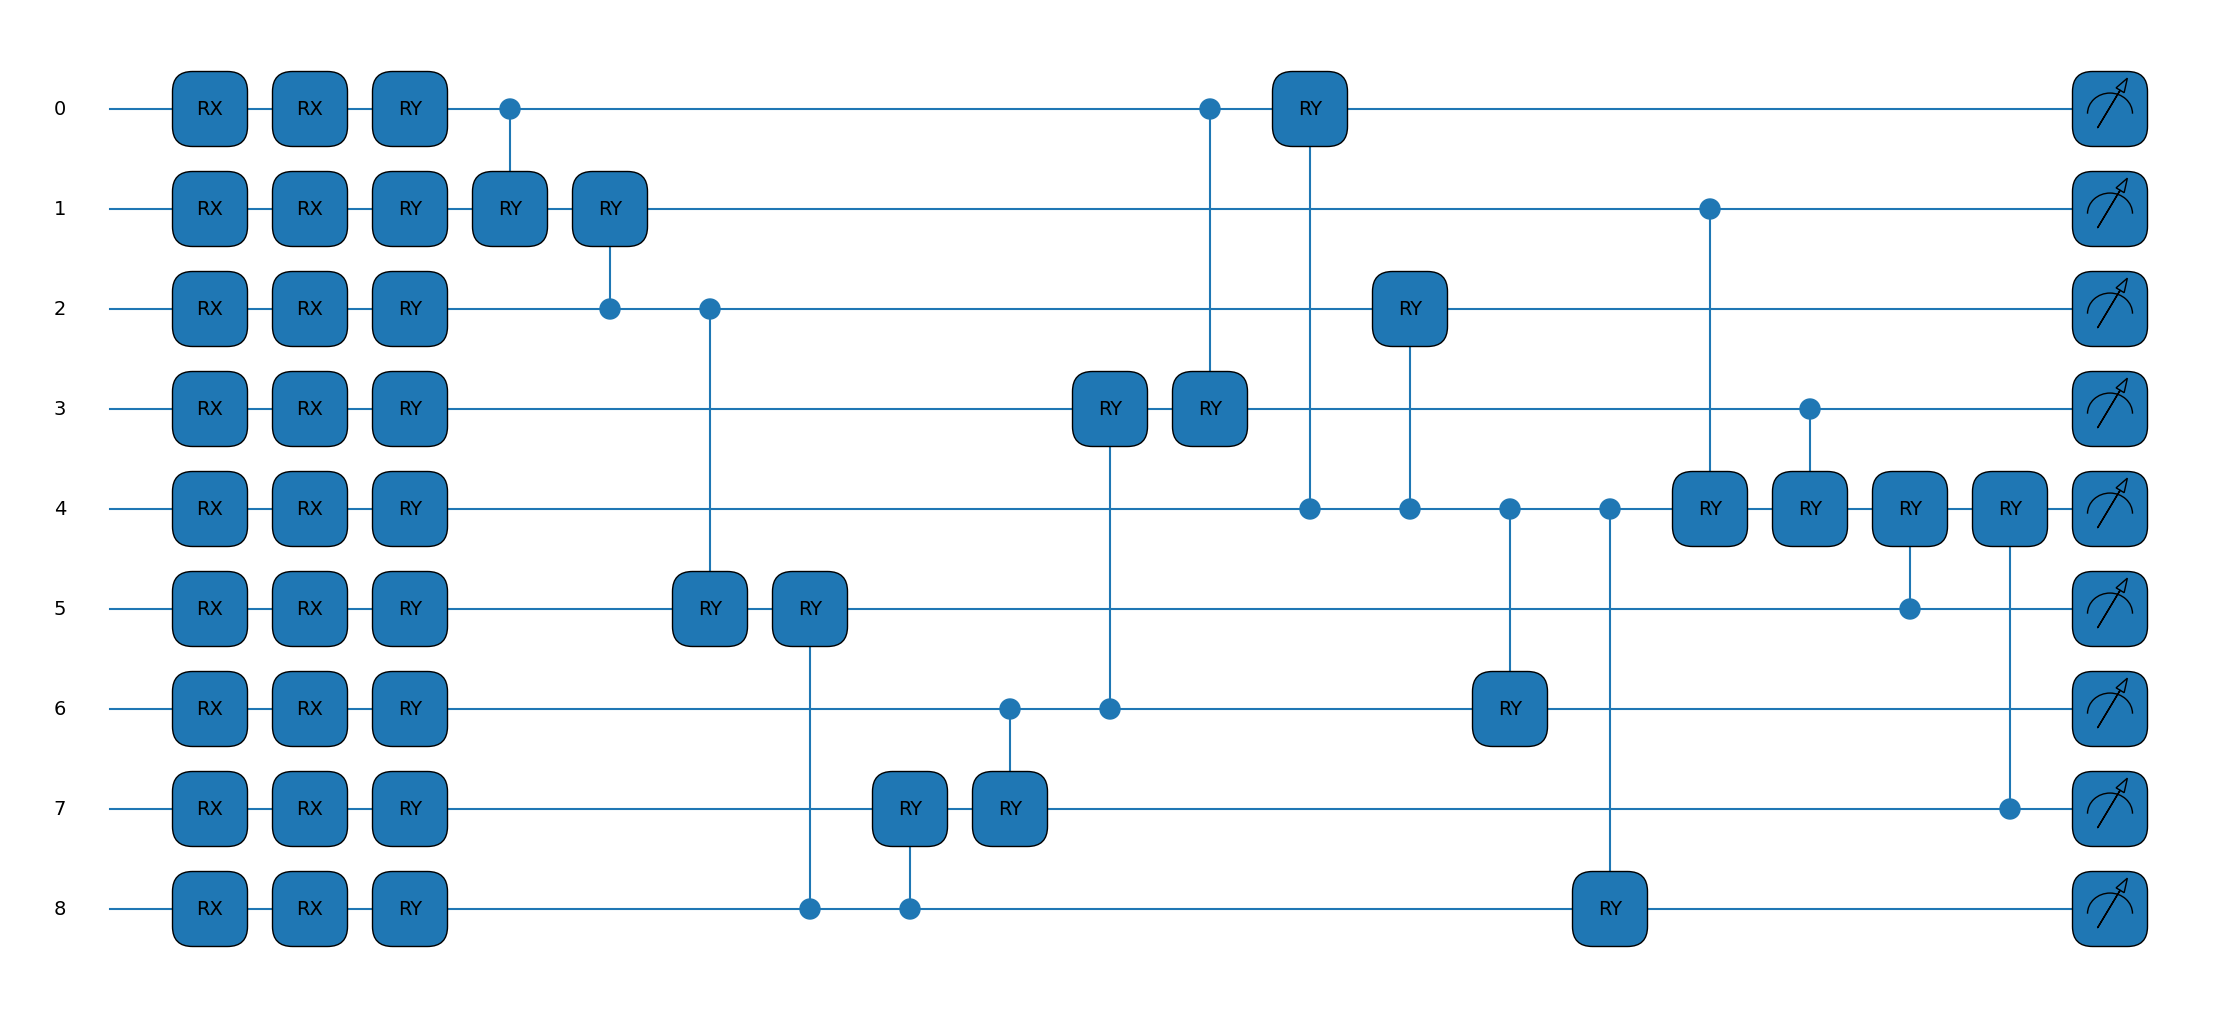

In [3]:
import pennylane as qml
import matplotlib.pyplot as plt

# Set up a nine-qubit system
dev = qml.device("default.qubit.torch", wires=9)

ob_center = qml.PauliZ(4)
ob_corner = (qml.PauliZ(0) + qml.PauliZ(2) + qml.PauliZ(6) + qml.PauliZ(8)) * (1 / 4)
ob_edge = (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(5) + qml.PauliZ(7)) * (1 / 4)

# Now let's encode the data in the following qubit models, first with symmetry
@qml.qnode(dev, interface="torch")
def circuit(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[2], wires=2)
    qml.RX(p[2], wires=6)
    qml.RX(p[2], wires=8)

    qml.RY(p[3], wires=0)
    qml.RY(p[3], wires=2)
    qml.RY(p[3], wires=6)
    qml.RY(p[3], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[4], wires=1)
    qml.RX(p[4], wires=3)
    qml.RX(p[4], wires=5)
    qml.RX(p[4], wires=7)

    qml.RY(p[5], wires=1)
    qml.RY(p[5], wires=3)
    qml.RY(p[5], wires=5)
    qml.RY(p[5], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[6], wires=[0, 1])
    qml.CRY(p[6], wires=[2, 1])
    qml.CRY(p[6], wires=[2, 5])
    qml.CRY(p[6], wires=[8, 5])
    qml.CRY(p[6], wires=[8, 7])
    qml.CRY(p[6], wires=[6, 7])
    qml.CRY(p[6], wires=[6, 3])
    qml.CRY(p[6], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[7], wires=[4, 0])
    qml.CRY(p[7], wires=[4, 2])
    qml.CRY(p[7], wires=[4, 6])
    qml.CRY(p[7], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[8], wires=[1, 4])
    qml.CRY(p[8], wires=[3, 4])
    qml.CRY(p[8], wires=[5, 4])
    qml.CRY(p[8], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit)([0] * 9, 18 * [0])

Let\'s also look at the same series of gates but this time they are applied independently from one another, so we won\'t be preserving the symmetries with our gate operations. Practically this also means more parameters, as previously groups of gates were updated together.


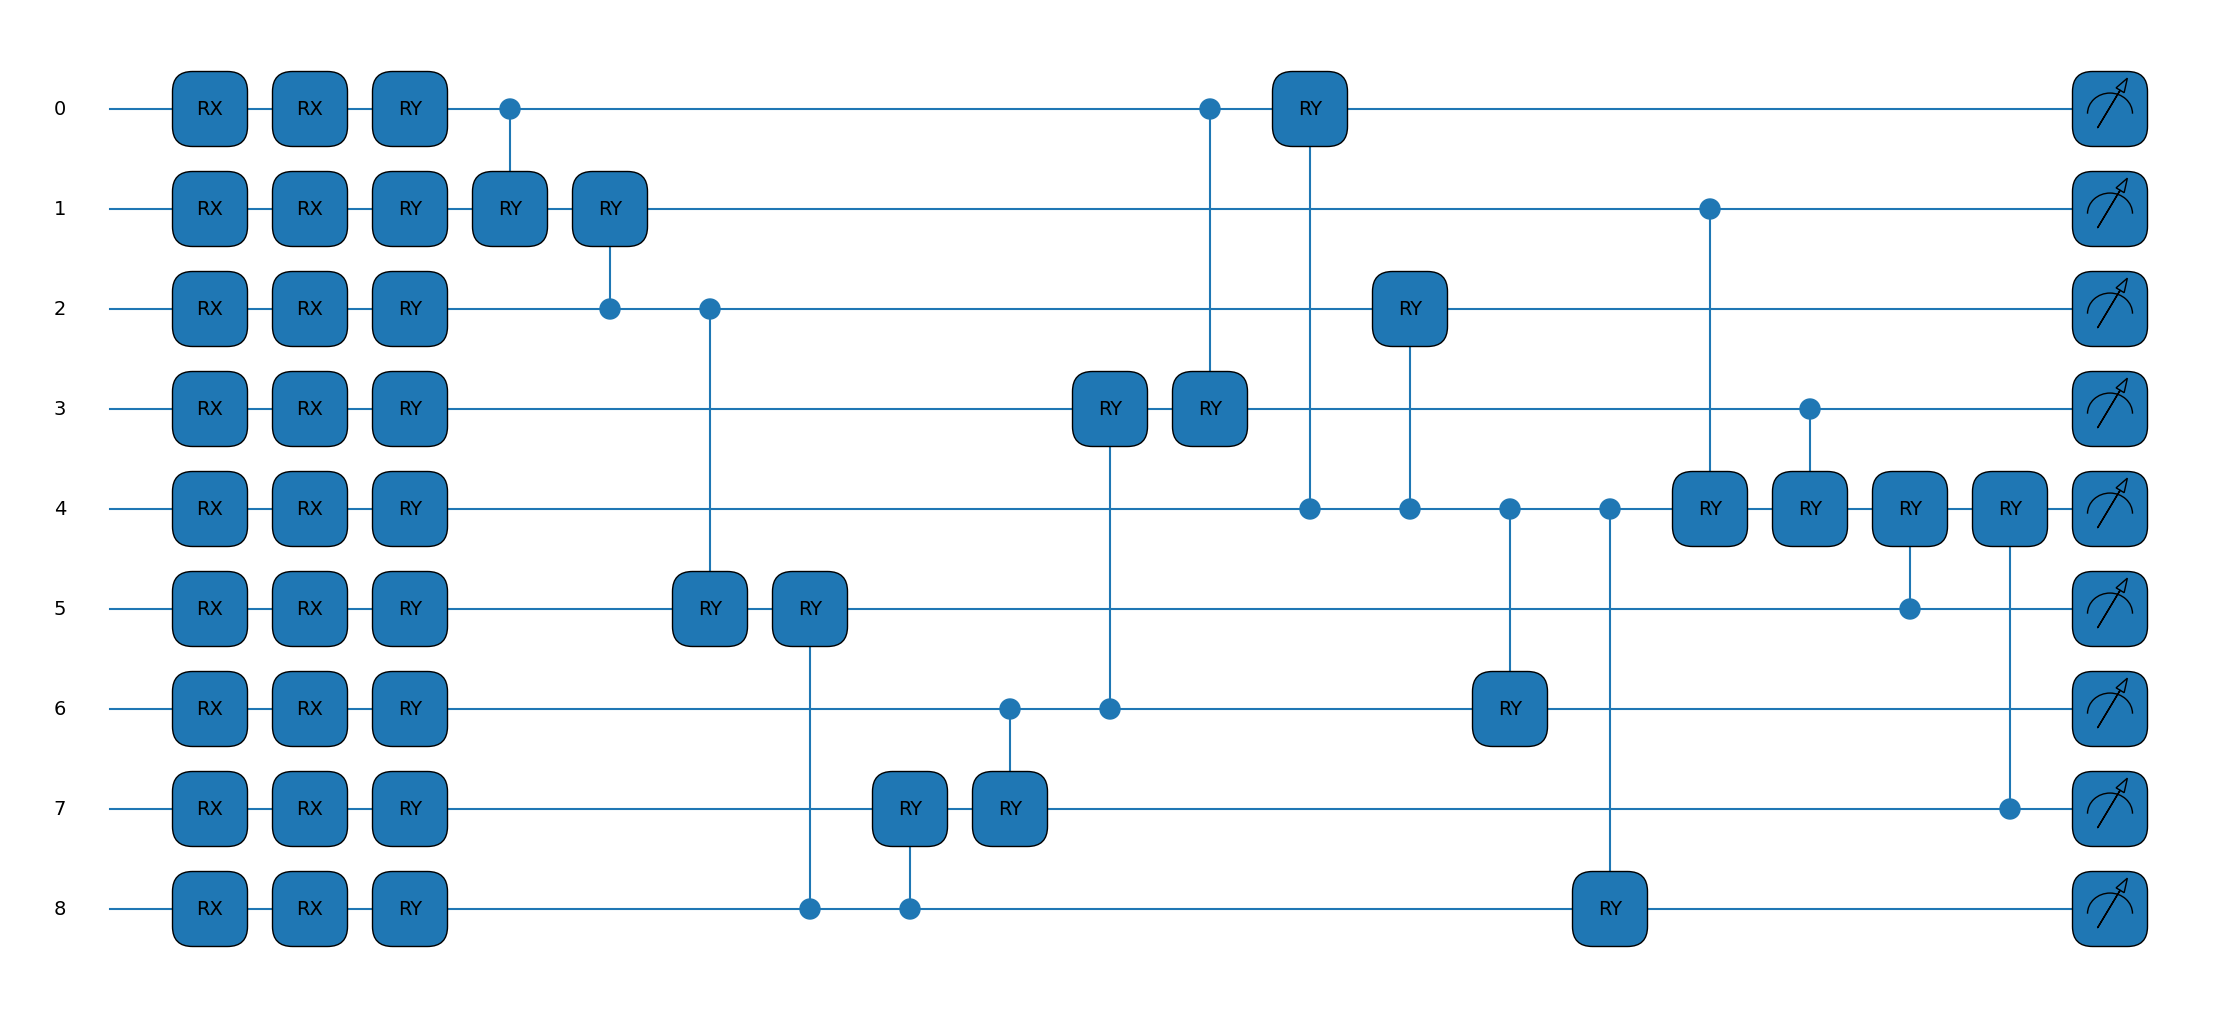

In [4]:
@qml.qnode(dev, interface="torch")
def circuit_no_sym(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Note in this circuit the parameters aren't all the same.
    # Previously they were identical to ensure they were applied
    # as one combined gate. The fact they can all vary independently
    # here means we aren't respecting the symmetry.

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[3], wires=2)
    qml.RX(p[4], wires=6)
    qml.RX(p[5], wires=8)

    qml.RY(p[6], wires=0)
    qml.RY(p[7], wires=2)
    qml.RY(p[8], wires=6)
    qml.RY(p[9], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[10], wires=1)
    qml.RX(p[11], wires=3)
    qml.RX(p[12], wires=5)
    qml.RX(p[13], wires=7)

    qml.RY(p[14], wires=1)
    qml.RY(p[15], wires=3)
    qml.RY(p[16], wires=5)
    qml.RY(p[17], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[18], wires=[0, 1])
    qml.CRY(p[19], wires=[2, 1])
    qml.CRY(p[20], wires=[2, 5])
    qml.CRY(p[21], wires=[8, 5])
    qml.CRY(p[22], wires=[8, 7])
    qml.CRY(p[23], wires=[6, 7])
    qml.CRY(p[24], wires=[6, 3])
    qml.CRY(p[25], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[26], wires=[4, 0])
    qml.CRY(p[27], wires=[4, 2])
    qml.CRY(p[28], wires=[4, 6])
    qml.CRY(p[29], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[30], wires=[1, 4])
    qml.CRY(p[31], wires=[3, 4])
    qml.CRY(p[32], wires=[5, 4])
    qml.CRY(p[33], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit_no_sym)([0] * 9, [0] * 34)

Note again how, though these circuits have a similar form to before, they are parameterised differently. We need to feed the vector $\boldsymbol{y}$ made up of the expectation value of these three operators into the loss function and use this to update our parameters.


In [5]:
import math

def encode_game(game):
    board, res = game
    x = board * (2 * math.pi) / 3
    if res == 1:
        y = [-1, -1, 1]
    elif res == -1:
        y = [1, -1, -1]
    else:
        y = [-1, 1, -1]
    return x, y

Recall that the loss function we\'re interested in is
$\mathcal{L}(\mathcal{D})=\frac{1}{|\mathcal{D}|} \sum_{(\boldsymbol{g}, \boldsymbol{y}) \in \mathcal{D}}\|\hat{\boldsymbol{y}}(\boldsymbol{g})-\boldsymbol{y}\|_{2}^{2}$.
We need to define this and then we can begin our optimisation.


In [6]:
# calculate the mean square error for this classification problem
def cost_function(params, input, target):
    output = torch.stack([circuit(x, params) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)

Let\'s now train our symmetry-preserving circuit on the data.


In [7]:
from torch import optim
import numpy as np

params = 0.01 * torch.randn(9)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)


max_epoch = 15
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([circuit(x, p) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy(params, *encoded_dataset_val)}")

x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs_sym = []
saved_accs_sym = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs_sym.append(cost)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy(params, *encoded_dataset_val)
        saved_accs_sym.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.2383333295583725
Epoch:  1 | Loss: 2.996221 | Validation accuracy: 0.153333
Epoch:  2 | Loss: 2.838961 | Validation accuracy: 0.415000
Epoch:  3 | Loss: 2.721652 | Validation accuracy: 0.535000
Epoch:  4 | Loss: 2.686487 | Validation accuracy: 0.553333
Epoch:  5 | Loss: 2.608699 | Validation accuracy: 0.548333
Epoch:  6 | Loss: 2.648471 | Validation accuracy: 0.591667
Epoch:  7 | Loss: 2.630698 | Validation accuracy: 0.585000
Epoch:  8 | Loss: 2.544674 | Validation accuracy: 0.585000
Epoch:  9 | Loss: 2.630653 | Validation accuracy: 0.570000
Epoch: 10 | Loss: 2.595081 | Validation accuracy: 0.576667
Epoch: 11 | Loss: 2.586225 | Validation accuracy: 0.578333
Epoch: 12 | Loss: 2.600443 | Validation accuracy: 0.578333
Epoch: 13 | Loss: 2.652541 | Validation accuracy: 0.576667
Epoch: 14 | Loss: 2.585265 | Validation accuracy: 0.580000
Epoch: 15 | Loss: 2.598611 | Validation accuracy: 0.580000


Now we train the non-symmetry preserving circuit.


In [8]:
params = 0.01 * torch.randn(34)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)

# calculate mean square error for this classification problem


def cost_function_no_sym(params, input, target):
    output = torch.stack([circuit_no_sym(x, params) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)


max_epoch = 15
max_step = 30
batch_size = 15

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy_no_sym(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([circuit_no_sym(x, p) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy_no_sym(params, *encoded_dataset_val)}")


x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs = []
saved_accs = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function_no_sym(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs.append(costs)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy_no_sym(params, *encoded_dataset_val)
        saved_accs.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.22166666388511658
Epoch:  1 | Loss: 3.025290 | Validation accuracy: 0.235000
Epoch:  2 | Loss: 2.918151 | Validation accuracy: 0.280000
Epoch:  3 | Loss: 2.824333 | Validation accuracy: 0.385000
Epoch:  4 | Loss: 2.747958 | Validation accuracy: 0.501667
Epoch:  5 | Loss: 2.693046 | Validation accuracy: 0.466667
Epoch:  6 | Loss: 2.659418 | Validation accuracy: 0.446667
Epoch:  7 | Loss: 2.641402 | Validation accuracy: 0.460000
Epoch:  8 | Loss: 2.626516 | Validation accuracy: 0.481667
Epoch:  9 | Loss: 2.616884 | Validation accuracy: 0.480000
Epoch: 10 | Loss: 2.610851 | Validation accuracy: 0.496667
Epoch: 11 | Loss: 2.606585 | Validation accuracy: 0.508333
Epoch: 12 | Loss: 2.599107 | Validation accuracy: 0.506667
Epoch: 13 | Loss: 2.592962 | Validation accuracy: 0.505000
Epoch: 14 | Loss: 2.589474 | Validation accuracy: 0.515000
Epoch: 15 | Loss: 2.584630 | Validation accuracy: 0.518333


Finally let\'s plot the results and see how the two training regimes differ.


/tmp/ipykernel_41313/356678465.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


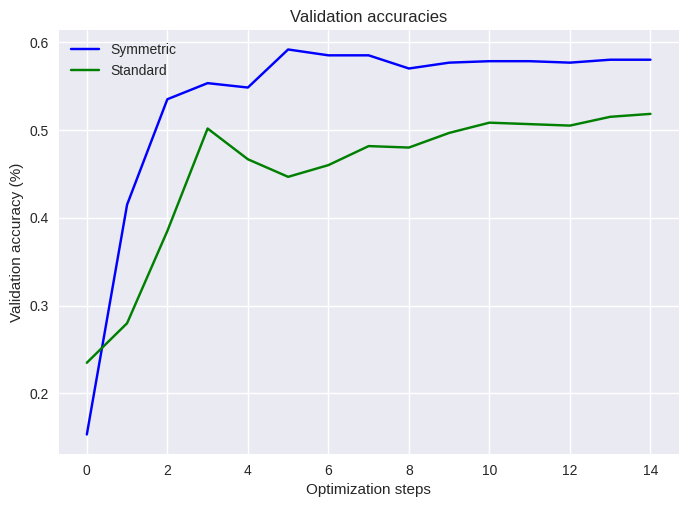

In [9]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.title("Validation accuracies")
plt.plot(saved_accs_sym, "b", label="Symmetric")
plt.plot(saved_accs, "g", label="Standard")

plt.ylabel("Validation accuracy (%)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

What we can see then is that by paying attention to the symmetries intrinsic to the learning problem and reflecting this in an equivariant gate set we have managed to improve our learning accuracies, while also
using fewer parameters. While the symmetry-aware circuit clearly outperforms the naive one, it is notable however that the learning accuracies in both cases are hardly ideal given this is a solved game.
So paying attention to symmetries definitely helps, but it also isn\'t a magic bullet!


The use of symmetries in both quantum and classsical machine learning is a developing field, so we can expect new results to emerge over the coming years. If you want to get involved, the references given below
are a great place to start.


# Send it after class:

Use the same approach to predict if a starting configuration in peg solitaire will be an outlier or "genius" (see https://www.cut-the-knot.org/proofs/PegsAndGroups.shtml)

# The Quantum Graph Recurrent Neural Network


This demonstration investigates quantum graph recurrent neural networks (QGRNN), which are the quantum analogue of a classical graph recurrent neural network, and a subclass of the more general quantum graph neural
network ansatz. Both the QGNN and QGRNN were introduced in [this paper (2019)](https://arxiv.org/abs/1909.12264).


## The Idea



A graph is defined as a set of *nodes* along with a set of **edges**, which represent connections between nodes. Information can be encoded into graphs by assigning numbers to nodes and edges, which we call
**weights**. It is usually convenient to think of a graph visually:

![image](images/graph4.png)

In recent years, the concept of a [graph neural network](https://arxiv.org/abs/1812.08434) (GNN) has been receiving a lot of attention from the machine learning community. A GNN seeks to learn a representation (a mapping of data into a low-dimensional vector space) of a given graph with feature vectors assigned to nodes and edges. Each of the vectors in the learned representation preserves not only the features, but also the overall topology of the graph, i.e., which nodes are connected by edges. The quantum graph neural network attempts to do something similar, but for features that are quantum-mechanical; for instance, a collection of quantum states.


Consider the class of qubit Hamiltonians that are *quadratic*, meaning that the terms of the Hamiltonian represent either interactions between two qubits, or the energy of individual qubits. This class of
Hamiltonians is naturally described by graphs, with second-order terms between qubits corresponding to weighted edges between nodes, and first-order terms corresponding to node weights.

A well known example of a quadratic Hamiltonian is the transverse-field Ising model, which is defined as

$$\hat{H}_{\text{Ising}}(\boldsymbol\theta) \ = \ \displaystyle\sum_{(i, j) \in E}
\theta_{ij}^{(1)} Z_{i} Z_{j} \ + \ \displaystyle\sum_{i} \theta_{i}^{(2)} Z_{i} \ + \
\displaystyle\sum_{i} X_{i},$$

where $\boldsymbol\theta \ = \ \{\theta^{(1)}, \ \theta^{(2)}\}$. In this Hamiltonian, the set $E$ that determines which pairs of qubits have $ZZ$ interactions can be represented by the set of edges for some graph. With the qubits as nodes, this graph is called the *interaction graph*. The $\theta^{(1)}$ parameters correspond to the edge weights and the $\theta^{(2)}$ parameters correspond to weights on the nodes.


This result implies that we can think about *quantum circuits* with graph-theoretic properties. Recall that the time-evolution operator with respect to some Hamiltonian $H$ is defined as:

$$U \ = \ e^{-it H}.$$

Thus, we have a clean way of taking quadratic Hamiltonians and turning them into unitaries (quantum circuits) that preserve the same correspondance to a graph. In the case of the Ising Hamiltonian, we have:

$$
U_{\text{Ising}}  =  e^{-it \hat{H}_{\text{Ising}} (\boldsymbol\theta)}  =  \exp \left[ -it \left( \sum_{(i, j) \in E} \theta_{ij}^{(1)} Z_{i} Z_{j}  +
\sum_{i} \theta_{i}^{(2)} Z_{i}  +  \sum_{i} X_{i} \right) \right]
$$

In general, this kind of unitary is very difficult to implement on a quantum computer. However, we can approximate it using the [Trotter-Suzuki decomposition](https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion):

$$ \exp \left[ -it \left( \sum_{(i, j) \in E} \theta_{ij}^{(1)} Z_{i} Z_{j}  +
\sum_{i} \theta_{i}^{(2)} Z_{i}  +  \sum_{i} X_{i} \right) \right] \approx \prod_{k \ = \ 1}^{t / \Delta} \left[ \displaystyle\prod_{j  =
1}^{Q} e^{-i \Delta \hat{H}_{\text{Ising}}^{j}(\boldsymbol\theta)} \right]$$

where $\hat{H}_{\text{Ising}}^{j}(\boldsymbol\theta)$ is the $j$-th term of the Ising Hamiltonian and $\Delta$ is some small number.

This circuit is a specific instance of the **Quantum Graph Recurrent Neural Network**, which in general is defined as a variational ansatz of the form

$$U_{H}(\boldsymbol\mu, \ \boldsymbol\gamma) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} \Bigg[
\displaystyle\prod_{j \ = \ 1}^{Q} e^{-i \gamma_j H^{j}(\boldsymbol\mu)} \Bigg],$$

for some parametrized quadratic Hamiltonian, $H(\boldsymbol\mu)$.


## Using the QGRNN



Since the QGRNN ansatz is equivalent to the approximate time evolution of some quadratic Hamiltonian, we can use it to learn the dynamics of a quantum system.

Continuing with the Ising model example, let\'s imagine we have some system governed by $\hat{H}_{\text{Ising}}(\boldsymbol\alpha)$ for an unknown set of target parameters, $\boldsymbol\alpha$ and an unknown interaction graph $G$. Let\'s also suppose we have access to copies of some low-energy, non-ground state of the target Hamiltonian, $|\psi_0\rangle$. In addition, we have access to a collection of time-evolved states, $\{ |\psi(t_1)\rangle, \ |\psi(t_2)\rangle, \ ..., \ |\psi(t_N)\rangle \}$, defined by:

$$|\psi(t_k)\rangle \ = \ e^{-i t_k \hat{H}_{\text{Ising}}(\boldsymbol\alpha)} |\psi_0\rangle.$$

We call the low-energy states and the collection of time-evolved states *quantum data*. From here, we randomly pick a number of time-evolved states from our collection. For any state that we choose, which is evolved to some time $t_k$, we compare it to

$$U_{\hat{H}_{\text{Ising}}}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle \ \approx \ e^{-i t_k
\hat{H}_{\text{Ising}}(\boldsymbol\mu)} |\psi_0\rangle.$$

This is done by feeding one of the copies of $|\psi_0\rangle$ into a quantum circuit with the QGRNN ansatz, with some guessed set of parameters $\boldsymbol\mu$ and a guessed interaction graph, $G'$. We then use a classical optimizer to maximize the average \"similarity\" between the time-evolved states and the states prepared with the QGRNN.

As the QGRNN states becomes more similar to each time-evolved state for each sampled time, it follows that $\boldsymbol\mu \ \rightarrow \ \boldsymbol\alpha$ and we are able to learn the unknown parameters of the Hamiltonian.

![A visual representation of one execution of the QGRNN for one piece of
quantum data.](images/qgrnn3.png)


## Learning an Ising Model with the QGRNN



We now attempt to use the QGRNN to learn the parameters corresponding to an arbitrary transverse-field Ising model Hamiltonian.


## Getting Started



We begin by importing the necessary dependencies:


In [10]:
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

We also define some fixed values that are used throughout the simulation.


In [11]:
qubit_number = 4
qubits = range(qubit_number)

In this simulation, we don\'t have quantum data readily available to pass into the QGRNN, so we have to generate it ourselves. To do this, we must have knowledge of the target interaction graph and the target Hamiltonian.

Let us use the following cyclic graph as the target interaction graph of the Ising Hamiltonian:


Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


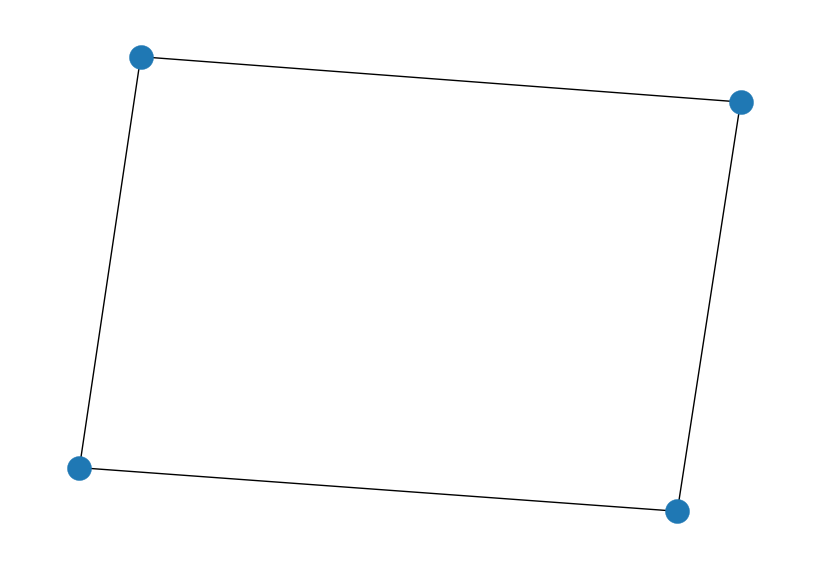

In [12]:
ising_graph = nx.cycle_graph(qubit_number)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

We can then initialize the "unknown" target parameters that describe the target Hamiltonian,

$\boldsymbol\alpha \ = \ \{\alpha^{(1)}, \ \alpha^{(2)}\}$. Recall from

the introduction that we have defined our parametrized Ising Hamiltonian to be of the form:

$$\hat{H}_{\text{Ising}}(\boldsymbol\theta)  =  \sum_{(i, j) \in E}
\theta_{ij}^{(1)} Z_{i} Z_{j}  +  \sum_{i} \theta_{i}^{(2)} Z_{i}  +
\sum_{i} X_{i},$$

where $E$ is the set of edges in the interaction graph, and $X_i$ and $Z_i$ are the Pauli-X and Pauli-Z on the $i$-th qubit.

For this tutorial, we choose the target parameters by sampling from a uniform probability distribution ranging from $-2$ to $2$, with
two-decimal precision.


In [13]:
target_weights = [0.56, 1.24, 1.67, -0.79]
target_bias = [-1.44, -1.43, 1.18, -0.93]

In theory, these parameters can be any value we want, provided they are reasonably small enough that the QGRNN can reach them in a tractable number of optimization steps. In `matrix_params`, the first list represents the $ZZ$ interaction parameters and the second list represents the single-qubit $Z$ parameters.

Finally, we use this information to generate the matrix form of the Ising model Hamiltonian in the computational basis:


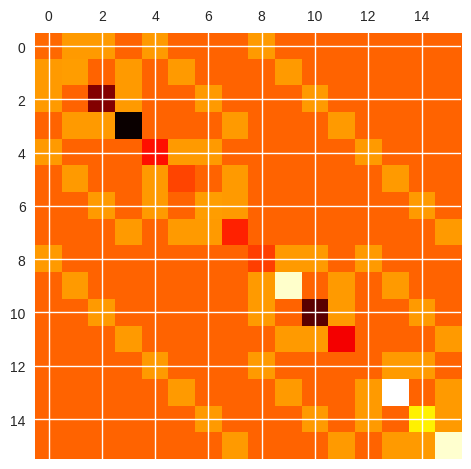

In [14]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, qml.matrix(qml.PauliZ)(0))
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix


# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, target_weights, target_bias)
plt.matshow(ham_matrix, cmap="hot")
plt.show()

## Preparing Quantum Data



The collection of quantum data needed to run the QGRNN has two components: (i) copies of a low-energy state, and (ii) a collection of time-evolved states, each of which are simply the low-energy state evolved to different times. The following is a low-energy state of the target Hamiltonian:


In [15]:
low_energy_state = [
    (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),
]

This state can be obtained by using a decoupled version of the `Variational Quantum Eigensolver` algorithm (VQE). Essentially, we choose a VQE ansatz such that the circuit cannot learn the exact ground state, but it can get
fairly close. Another way to arrive at the same result is to perform VQE with a reasonable ansatz, but to terminate the algorithm before it converges to the ground state. If we used the exact ground state $|\psi_0\rangle$, the time-dependence would be trivial and the data would not provide enough information about the Hamiltonian parameters.

We can verify that this is a low-energy state by numerically finding the lowest eigenvalue of the Hamiltonian and comparing it to the energy expectation of this low-energy state:


In [16]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189116
Ground State Energy: -7.330689661291244


We have in fact found a low-energy, non-ground state, as the energy expectation is slightly greater than the energy of the true ground state. This, however, is only half of the information we need. We also require a collection of time-evolved, low-energy states. Evolving the low-energy state forward in time is fairly straightforward: all we have to do is multiply the initial state by a time-evolution unitary. This operation can be defined as a custom gate in PennyLane:


In [17]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j * hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

We don\'t actually generate time-evolved quantum data quite yet, but we now have all the pieces required for its preparation.


## Learning the Hamiltonian


With the quantum data defined, we are able to construct the QGRNN and learn the target Hamiltonian. Each of the exponentiated Hamiltonians in the QGRNN ansatz, $\hat{H}^{j}_{\text{Ising}}(\boldsymbol\mu)$, are the $ZZ$, $Z$, and $X$ terms from the Ising Hamiltonian. This gives:


In [18]:
def qgrnn_layer(weights, bias, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        qml.MultiRZ(2 * weights[i] * trotter_step, wires=(edge[0], edge[1]))

    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        qml.RZ(2 * bias[i] * trotter_step, wires=qubit)

    # Applies a layer of RX gates
    for qubit in qubits:
        qml.RX(2 * trotter_step, wires=qubit)

As was mentioned in the first section, the QGRNN has two registers. In one register, some piece of quantum data $|\psi(t)\rangle$ is prepared and in the other we have $U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle$. We need a way to measure the similarity between these states. This can be done by using the fidelity, which is simply the modulus squared of the inner product between the states, $| \langle \psi(t) | U_{H}(\Delta, \ \boldsymbol\mu) |\psi_0\rangle |^2$.

To calculate this value, we use a [SWAP test](https://en.wikipedia.org/wiki/Swap_test) between the registers:


In [19]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        qml.CSWAP(wires=(control, reg1_qubit, reg2_qubit))
    qml.Hadamard(wires=control)

After performing this procedure, the value returned from a measurement of the circuit is $\langle Z \rangle$, with respect to the `control` qubit. The probability of measuring the $|0\rangle$ state in this control qubit is related to both the fidelity between registers and $\langle Z \rangle$. Thus, with a bit of algebra, we find that $\langle Z \rangle$ is equal to the fidelity.

Before creating the full QGRNN and the cost function, we define a few more fixed values. Among these is a \"guessed\" interaction graph, which we set to be a [complete graph](https://en.wikipedia.org/wiki/Complete_graph). This choice is motivated by the fact that any target interaction graph will be a subgraph of this initial guess. Part of the idea behind the QGRNN is that we don't know the interaction graph, and it has to be learned. In this case, the graph is learned *automatically* as the target parameters are optimized. The $\boldsymbol\mu$ parameters that correspond to edges that don\'t exist in the target graph will simply approach $0$.


Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


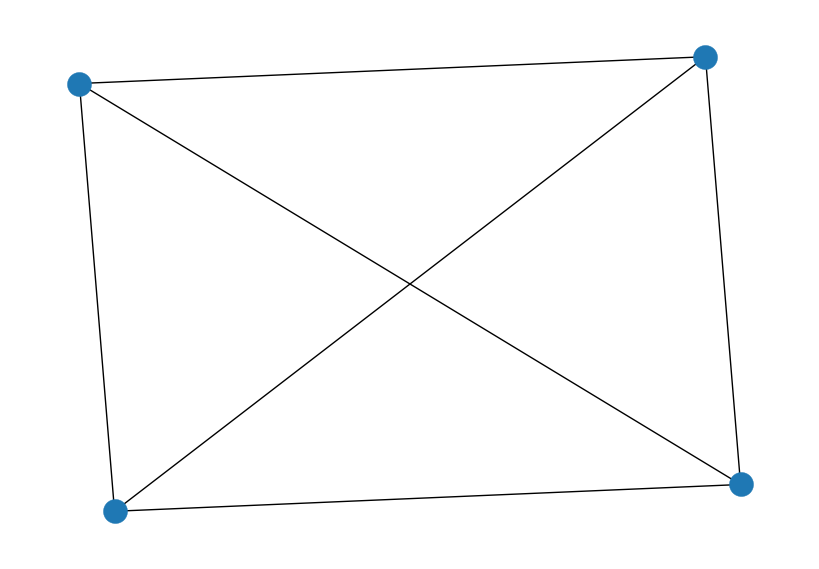

In [20]:
# Defines some fixed values

reg1 = tuple(range(qubit_number))  # First qubit register
reg2 = tuple(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.complete_graph(reg2)

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

With this done, we implement the QGRNN circuit for some given time value:


In [21]:
def qgrnn(weights, bias, time=None):

    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state, low_energy_state), wires=reg1 + reg2)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        qgrnn_layer(weights, bias, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)

    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

We have the full QGRNN circuit, but we still need to define a cost function. We know that $| \langle \psi(t) | U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle |^2$
approaches $1$ as the states become more similar and approaches $0$ as the states become orthogonal. Thus, we choose to minimize the quantity $-| \langle \psi(t) | U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle |^2$.
Since we are interested in calculating this value for many different pieces of quantum data, the final cost function is the average negative fidelity\* between registers:

$$\mathcal{L}(\boldsymbol\mu, \ \Delta) \ = \ - \frac{1}{N} \displaystyle\sum_{i \ = \ 1}^{N} | \langle \psi(t_i) | \ U_{H}(\boldsymbol\mu, \ \Delta) \ |\psi_0\rangle |^2,$$

where we use $N$ pieces of quantum data.

Before creating the cost function, we must define a few more fixed variables:


In [22]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

We then define the negative fidelity cost function:


In [23]:
rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result

    return total_cost / N

Next we set up for optimization.


In [24]:
# Defines the new device
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode
qgrnn_qnode = qml.QNode(qgrnn, qgrnn_dev)

steps = 300

optimizer = qml.AdamOptimizer(stepsize=0.5)

weights = rng.random(size=len(new_ising_graph.edges), requires_grad=True) - 0.5
bias = rng.random(size=qubit_number, requires_grad=True) - 0.5

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

All that remains is executing the optimization loop.


In [25]:
for i in range(0, steps):
    (weights, bias), cost = optimizer.step_and_cost(cost_function, weights, bias)

    # Prints the value of the cost function
    if i % 5 == 0:
        print(f"Cost at Step {i}: {cost}")
        print(f"Weights at Step {i}: {weights}")
        print(f"Bias at Step {i}: {bias}")
        print("---------------------------------------------")

Cost at Step 0: -0.9803638573791906
Weights at Step 0: [-0.22603613  0.43887001  0.85859236  0.69735898  0.09417125 -0.02437147]
Bias at Step 0: [-0.23884748 -0.21392016  0.12809368  0.45037793]
---------------------------------------------
Cost at Step 5: -0.997458952442803
Weights at Step 5: [-0.75106068  1.078707    0.83766935  1.9741555   0.04982793 -0.06747815]
Bias at Step 5: [-0.50836435 -1.32708118  1.57468372  0.11442806]
---------------------------------------------
Cost at Step 10: -0.9971878268304797
Weights at Step 10: [ 0.01577799  0.48771566  0.68379977  1.75747002 -0.21948418 -0.00484698]
Bias at Step 10: [ 0.22007905 -0.90282076  1.58989008 -0.1051542 ]
---------------------------------------------
Cost at Step 15: -0.9981871533122741
Weights at Step 15: [-0.06744249  0.65720464  1.31471457  1.47430241  0.05813038 -0.41315658]
Bias at Step 15: [-0.29045223 -0.67045595  1.19395446  0.24677711]
---------------------------------------------
Cost at Step 20: -0.99951306921

With the learned parameters, we construct a visual representation of the Hamiltonian to which they correspond and compare it to the target Hamiltonian, and the initial guessed Hamiltonian:


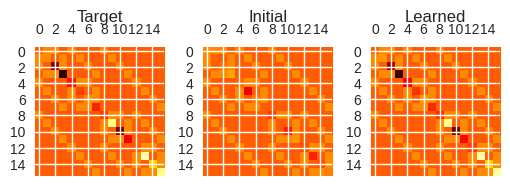

In [26]:
new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), weights, bias
)

init_ham = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

These images look very similar, indicating that the QGRNN has done a good job learning the target Hamiltonian.

We can also look at the exact values of the target and learned parameters. Recall how the target interaction graph has $4$ edges while
the complete graph has $6$. Thus, as the QGRNN converges to the optimal solution, the weights corresponding to edges $(1, 3)$ and $(2, 0)$ in
the complete graph should go to $0$, as this indicates that they have no effect, and effectively do not exist in the learned Hamiltonian.


In [27]:
# We first pick out the weights of edges (1, 3) and (2, 0)
# and then remove them from the list of target parameters

weights_noedge = []
weights_edge = []
for ii, edge in enumerate(new_ising_graph.edges):
    if (edge[0] - qubit_number, edge[1] - qubit_number) in ising_graph.edges:
        weights_edge.append(weights[ii])
    else:
        weights_noedge.append(weights[ii])

Then, we print all of the weights:


In [28]:
print("Target parameters     Learned parameters")
print("Weights")
print("-" * 41)
for ii_target, ii_learned in zip(target_weights, weights_edge):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print("\nBias")
print("-"*41)
for ii_target, ii_learned in zip(target_bias, bias):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print(f"\nNon-Existing Edge Parameters: {[val.unwrap() for val in weights_noedge]}")

Target parameters     Learned parameters
Weights
-----------------------------------------
0.56                |  0.5988034096092832
1.24                |  1.3483865512005249
1.67                |   1.786207064845589
-0.79               | -0.8425475506159178

Bias
-----------------------------------------
-1.44               | -1.4067983643944113
-1.43               | -1.3529638627173919
1.18                |   1.034912941983086
-0.93               |  -1.063587496659968

Non-Existing Edge Parameters: [-0.0012651471928199864, -0.003653447242327378]


The weights of edges $(1, 3)$ and $(2, 0)$ are very close to $0$, indicating we have learned the cycle graph from the complete graph. In addition, the remaining learned weights are fairly close to those of the
target Hamiltonian. Thus, the QGRNN is functioning properly, and has learned the target Ising Hamiltonian to a high degree of accuracy!


## Send it after class:

The imaginary-time evolution method is a well-known approach used for obtaining the ground state in quantum many-body problems (see https://physics.stackexchange.com/questions/557225/why-do-we-use-the-imaginary-time-evolution-in-simulations-of-some-quantum-system)

Find the ground state of a quadratic Hamiltonian (i.e. something in the class of traverse field Ising model) using imaginary time evolution